In [1]:
import os, sys
cwd = os.getcwd()

api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
api_path_cifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')


sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)
sys.path.append(api_path_cifar)

import os
import re
from typing import List, Optional

import click
import numpy as np
import PIL.Image
import torch
import random
from functools import partial
from tqdm import tqdm

from matplotlib import pyplot as plt

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy,
                          gan_energy_stylegan2_ada)
from general_utils import to_var, to_np, DotDict

from cifar10_utils import save_images_for_fid_fix_latent

import time
from metrics import inception_score

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from fid_score import calculate_fid_given_paths
from distributions import IndependentNormal

In [18]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [19]:
device = torch.device('cuda:1')
D = model.getOriginalD()
G = model.getOriginalG()
G = G.eval().requires_grad_(False).to(device)
D = D.eval().requires_grad_(False).to(device)

In [20]:
num_images = 32
noise, _ = model.buildNoiseData(num_images)
noise = noise.to(device)
generated_images = G(noise)

In [21]:
D(generated_images)

tensor([[ 1.6316],
        [ 0.6271],
        [-2.1793],
        [ 0.5504],
        [ 1.5895],
        [ 1.0649],
        [ 2.1929],
        [ 2.4509],
        [ 2.5986],
        [ 0.8828],
        [ 1.2782],
        [ 2.7130],
        [-0.4843],
        [ 0.1036],
        [ 1.2691],
        [ 0.6137],
        [ 1.1274],
        [ 0.8783],
        [ 0.1456],
        [ 0.8712],
        [ 0.6914],
        [-0.6868],
        [ 0.9187],
        [ 0.5306],
        [-2.4387],
        [ 0.2865],
        [ 0.1146],
        [ 0.6380],
        [-0.2999],
        [ 1.7722],
        [ 0.1590],
        [-0.0941]], device='cuda:1')

In [22]:
generated_images.min()

tensor(-1.5542, device='cuda:1')

In [23]:
generated_images.max()

tensor(1.7528, device='cuda:1')

In [24]:
generated_images.shape

torch.Size([32, 3, 128, 128])

In [25]:
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size)])
generated_images_transform = (transform(generated_images).clamp(min=-1, max=1) + 1.)/2

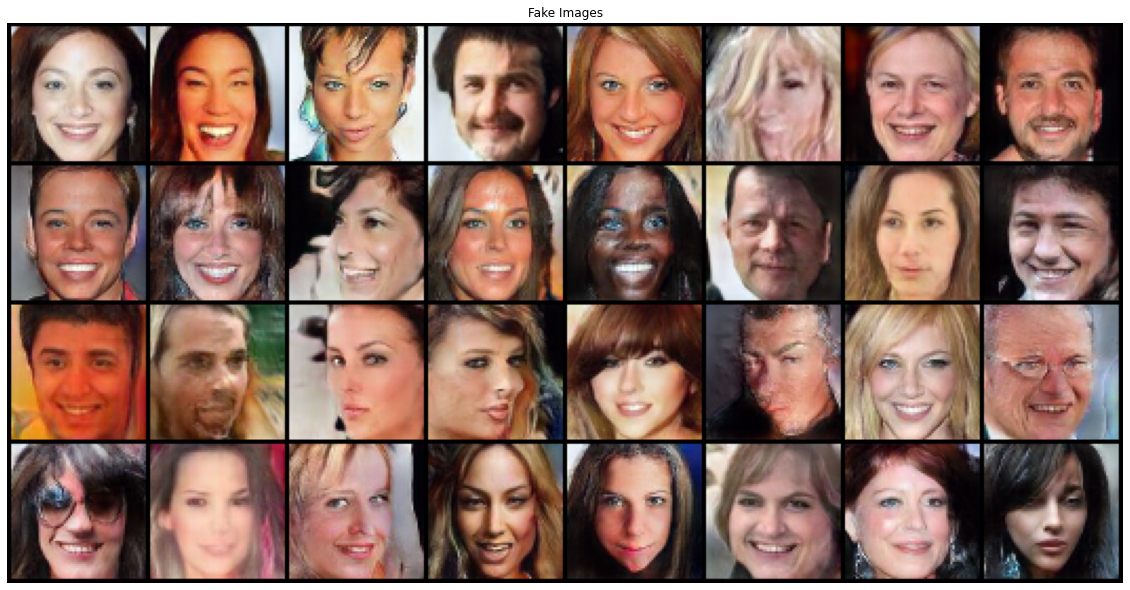

In [26]:
grid = torchvision.utils.make_grid(generated_images_transform, scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [19]:
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
workers = 2
batch_size = 32
real_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

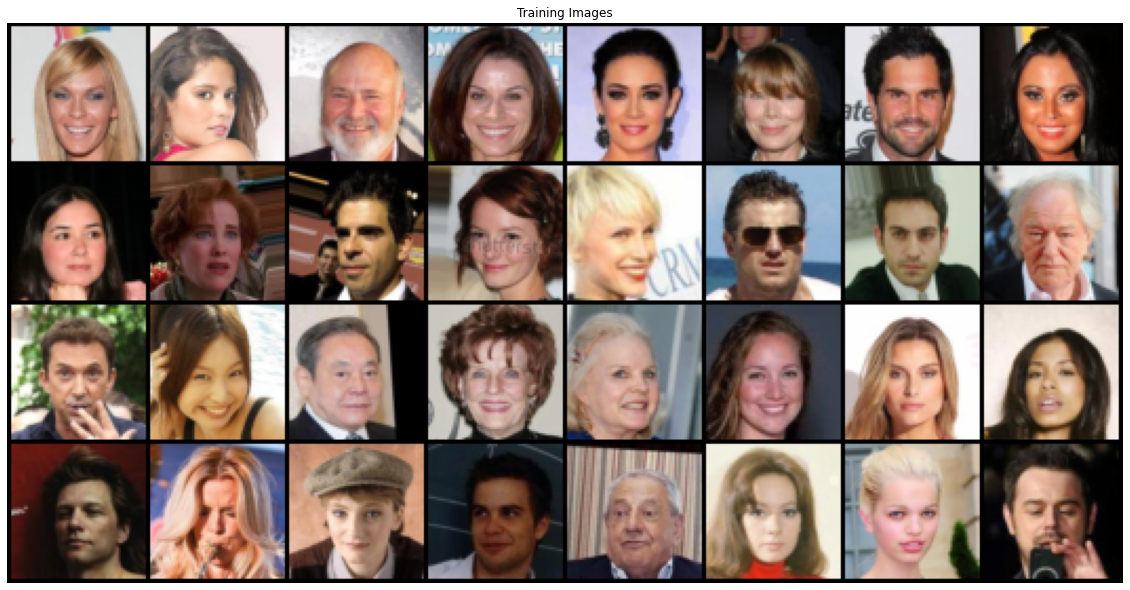

In [20]:
real_batch = next(iter(real_dataloader))
real_images = real_batch[0].to(device)[:64]
plt.figure(figsize=(20, 20))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_images, 
                                         padding=2, normalize=True).cpu(),
                        (1,2,0))
          )
plt.axis("off")
plt.show()

In [78]:
real_images.min()

tensor(-1., device='cuda:1')

In [79]:
real_images.max()

tensor(1., device='cuda:1')

In [7]:
real_images.shape

torch.Size([32, 3, 64, 64])

In [5]:
class LatentFixDatasetCeleba(torch.utils.data.Dataset):
    """Dataset for Generator
    """
    def __init__(self, latent_arr, G, device, nsamples):
        self.latent_arr = latent_arr
        self.G = G
        self.nsamples = nsamples
        self.transform=transforms.Compose([
            transforms.ToTensor()
        ])
        self.device = device

    def __getitem__(self, index):
        z = to_var(self.latent_arr[index].unsqueeze(0), self.device)
        with torch.no_grad():
            image = self.G(z)
        clamp_image = self.clamp(G(z).permute(0, 2, 3, 1))
        np_image = to_np(clamp_image)
        squeeze_image = np.squeeze(np_image)
        
        return self.transform(squeeze_image)

    def __len__(self):
        return self.nsamples

    def clamp(self, x):
        # For fake data generated with tanh(x)
        return (x.clamp(-1, 1) + 1.)/2.

In [6]:
nsamples = 50000
noise, _ = model.buildNoiseData(nsamples)
latent_dataset = LatentFixDatasetCeleba(noise, G, 
                                        device, nsamples)

In [6]:
start = time.time()
batch_size = 64
(inception_score_mean, 
 inception_score_std) = inception_score(latent_dataset, 
                                        device, 
                                        batch_size, True)
consumed_time = time.time() - start



Start to make predictions
Start to compute KL divergence


In [7]:
consumed_time


1632.5388934612274

In [9]:
inception_score_mean

3.0295146421481105

In [10]:
inception_score_std

0.01321523786761441

In [12]:
def save_images_for_fid_fix_latent(G,
                                   real_dataloader,
                                   name_fake_test,
                                   name_real_test,
                                   latent_arr,
                                   device,
                                   transformer,
                                   random_seed):
    fake_list = []
    real_list = []
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    max_num_imgs = latent_arr.shape[0]
    start_ind = 0

    for  i, data_real in tqdm(enumerate(real_dataloader, 0)):
        batch_real = data_real[0]
        batch_size = batch_real.shape[0]

        if (start_ind + batch_size <= max_num_imgs):
            fixed_noise = latent_arr[start_ind:start_ind + batch_size].to(device)
            fake_images = transformer(G(fixed_noise)).clamp(-1, 1)
            start_ind += batch_size

            fake_norm_np = ((1. + fake_images)/2).detach().cpu().numpy()
            real_norm_np = ((1. + batch_real)/2).detach().cpu().numpy()
            fake_list.append(fake_norm_np)
            real_list.append(real_norm_np)

        else:
            fixed_noise = latent_arr[start_ind:].to(device)
            fake_images = transformer(G(fixed_noise)).clamp(-1, 1)
            add_num_imgs = max_num_imgs - start_ind
            batch_real = batch_real[:add_num_imgs]

            fake_norm_np = ((1. + fake_images)/2).detach().cpu().numpy()
            real_norm_np = ((1. + batch_real)/2).detach().cpu().numpy()
            fake_list.append(fake_norm_np)
            real_list.append(real_norm_np)
            break

    fake_np = np.concatenate(fake_list)
    real_np = np.concatenate(real_list)

    print(f"shape of generated images = {fake_np.shape}")
    print(f"shape of real images = {real_np.shape}")

    np.save(name_fake_test, fake_np)
    np.save(name_real_test, real_np)

In [13]:
path_to_save_np = "/home/daniil/gans-mcmc/saved_numpy_arrays"
name_fake_train = os.path.join(path_to_save_np, "train_fake_celeba.npy")
name_real_train = os.path.join(path_to_save_np, "train_real_celeba.npy")
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size)])
random_seed = 42

nsamples = 50000
noise, _ = model.buildNoiseData(nsamples)

start = time.time()
save_images_for_fid_fix_latent(G,
                               real_dataloader,
                               name_fake_train,
                               name_real_train,
                               noise,
                               device, 
                               transform,
                               random_seed)   
consumed_time = time.time() - start

1562it [08:18,  3.13it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


In [14]:
chech = np.load(name_fake_train)

In [15]:
chech.shape

(50000, 3, 64, 64)

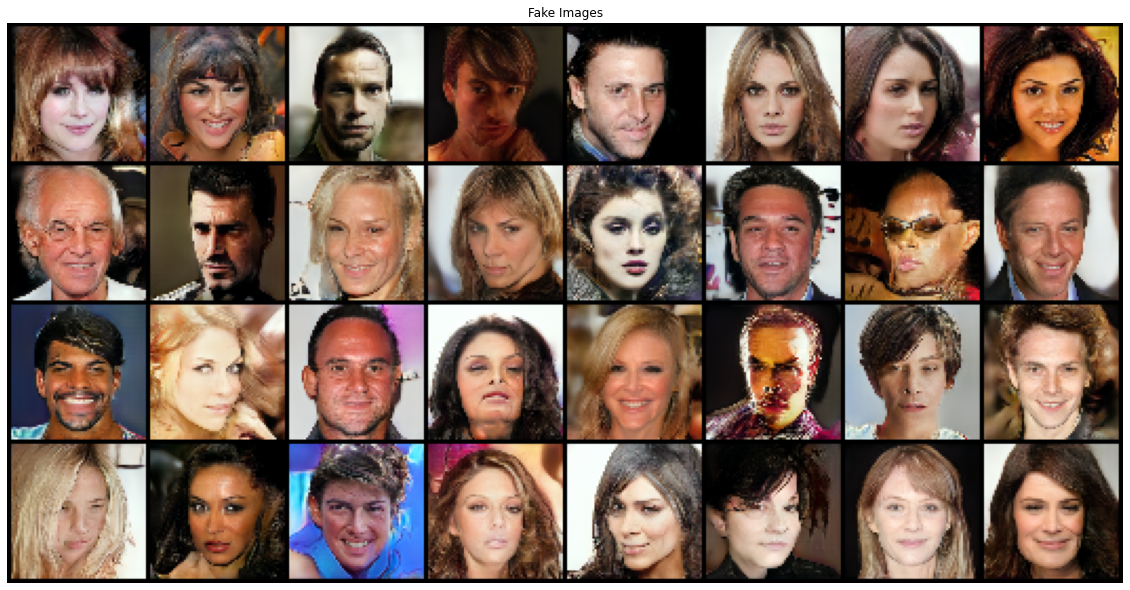

In [18]:
grid = torchvision.utils.make_grid(torch.FloatTensor(chech[:32]), scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [24]:
chech.min()

0.0

In [25]:
chech.max()

1.0

In [21]:
check = np.load(name_real_train)

In [22]:
check.min()

0.0

In [23]:
check.max()

1.0

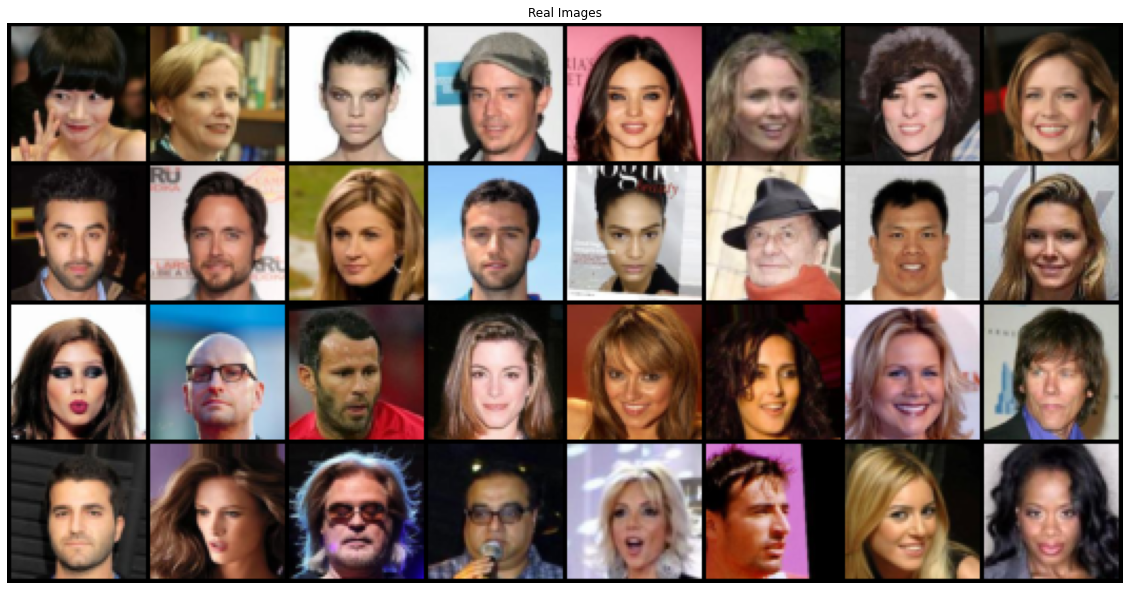

In [20]:
grid = torchvision.utils.make_grid(torch.FloatTensor(chech[:32]), scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Real Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [36]:
batch_size_resnet = 50
dim_resnet = 2048
model_type = 'inception'
cuda = True

paths_to_train_method = [name_real_train, name_fake_train]

results_fid_train = calculate_fid_given_paths(paths_to_train_method, 
                                           batch_size_resnet, 
                                           cuda, 
                                           dim_resnet, 
                                           model_type=model_type)

  0%|          | 2/1000 [00:00<01:26, 11.50it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/train_fake_celeba.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it, mean=19]


In [37]:
results_fid_train_first = results_fid_train[0]

mean_fid_train = results_fid_train_first[1]
std_fid_train = results_fid_train_first[2]
print(mean_fid_train)
print(std_fid_train)

19.04734363852969
0.08064274583875268


# ULA

In [2]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

device = torch.device('cuda:1')
D = model.getOriginalD().eval().requires_grad_(False).to(device)
G = model.getOriginalG().eval().requires_grad_(False).to(device)


Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:
noise, _ = model.buildNoiseData(1)
z_dim = noise.shape[1]

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 45
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  0%|          | 1/223 [01:23<5:08:30, 83.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (21, 45, 512)


  1%|          | 2/223 [02:49<5:09:53, 84.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_45.npy was saved, file shape = (21, 45, 512)


  1%|▏         | 3/223 [04:15<5:10:39, 84.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_90.npy was saved, file shape = (21, 45, 512)


  2%|▏         | 4/223 [05:41<5:10:39, 85.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_135.npy was saved, file shape = (21, 45, 512)


  2%|▏         | 5/223 [07:07<5:10:13, 85.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_180.npy was saved, file shape = (21, 45, 512)


  3%|▎         | 6/223 [08:33<5:09:29, 85.58s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_225.npy was saved, file shape = (21, 45, 512)


  3%|▎         | 7/223 [09:59<5:08:38, 85.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_270.npy was saved, file shape = (21, 45, 512)


  4%|▎         | 8/223 [11:25<5:07:38, 85.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_315.npy was saved, file shape = (21, 45, 512)


  4%|▍         | 9/223 [12:51<5:06:23, 85.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_360.npy was saved, file shape = (21, 45, 512)


  4%|▍         | 10/223 [14:17<5:05:07, 85.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_405.npy was saved, file shape = (21, 45, 512)


  5%|▍         | 11/223 [15:43<5:03:48, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_450.npy was saved, file shape = (21, 45, 512)


  5%|▌         | 12/223 [17:09<5:02:27, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_495.npy was saved, file shape = (21, 45, 512)


  6%|▌         | 13/223 [18:35<5:01:04, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_540.npy was saved, file shape = (21, 45, 512)


  6%|▋         | 14/223 [20:01<4:59:40, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_585.npy was saved, file shape = (21, 45, 512)


  7%|▋         | 15/223 [21:28<4:58:16, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_630.npy was saved, file shape = (21, 45, 512)


  7%|▋         | 16/223 [22:54<4:56:51, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_675.npy was saved, file shape = (21, 45, 512)


  8%|▊         | 17/223 [24:20<4:55:26, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_720.npy was saved, file shape = (21, 45, 512)


  8%|▊         | 18/223 [25:46<4:54:00, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_765.npy was saved, file shape = (21, 45, 512)


  9%|▊         | 19/223 [27:12<4:52:33, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_810.npy was saved, file shape = (21, 45, 512)


  9%|▉         | 20/223 [28:38<4:51:07, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_855.npy was saved, file shape = (21, 45, 512)


  9%|▉         | 21/223 [30:04<4:49:42, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_900.npy was saved, file shape = (21, 45, 512)


 10%|▉         | 22/223 [31:30<4:48:17, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_945.npy was saved, file shape = (21, 45, 512)


 10%|█         | 23/223 [32:56<4:46:51, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_990.npy was saved, file shape = (21, 45, 512)


 11%|█         | 24/223 [34:22<4:45:24, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1035.npy was saved, file shape = (21, 45, 512)


 11%|█         | 25/223 [35:48<4:43:56, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1080.npy was saved, file shape = (21, 45, 512)


 12%|█▏        | 26/223 [37:14<4:42:28, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1125.npy was saved, file shape = (21, 45, 512)


 12%|█▏        | 27/223 [38:40<4:41:02, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1170.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 28/223 [40:06<4:39:34, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1215.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 29/223 [41:32<4:38:08, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1260.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 30/223 [42:58<4:36:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1305.npy was saved, file shape = (21, 45, 512)


 14%|█▍        | 31/223 [44:24<4:35:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1350.npy was saved, file shape = (21, 45, 512)


 14%|█▍        | 32/223 [45:50<4:33:50, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1395.npy was saved, file shape = (21, 45, 512)


 15%|█▍        | 33/223 [47:16<4:32:24, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1440.npy was saved, file shape = (21, 45, 512)


 15%|█▌        | 34/223 [48:42<4:31:00, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1485.npy was saved, file shape = (21, 45, 512)


 16%|█▌        | 35/223 [50:08<4:29:33, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1530.npy was saved, file shape = (21, 45, 512)


 16%|█▌        | 36/223 [51:34<4:28:07, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1575.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 37/223 [53:00<4:26:42, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1620.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 38/223 [54:26<4:25:18, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1665.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 39/223 [55:53<4:23:53, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1710.npy was saved, file shape = (21, 45, 512)


 18%|█▊        | 40/223 [57:19<4:22:29, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1755.npy was saved, file shape = (21, 45, 512)


 18%|█▊        | 41/223 [58:45<4:21:03, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1800.npy was saved, file shape = (21, 45, 512)


 19%|█▉        | 42/223 [1:00:11<4:19:37, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1845.npy was saved, file shape = (21, 45, 512)


 19%|█▉        | 43/223 [1:01:37<4:18:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1890.npy was saved, file shape = (21, 45, 512)


 20%|█▉        | 44/223 [1:03:03<4:16:43, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1935.npy was saved, file shape = (21, 45, 512)


 20%|██        | 45/223 [1:04:29<4:15:17, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1980.npy was saved, file shape = (21, 45, 512)


 21%|██        | 46/223 [1:05:55<4:13:48, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2025.npy was saved, file shape = (21, 45, 512)


 21%|██        | 47/223 [1:07:21<4:12:21, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2070.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 48/223 [1:08:47<4:10:55, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2115.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 49/223 [1:10:13<4:09:29, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2160.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 50/223 [1:11:39<4:08:04, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2205.npy was saved, file shape = (21, 45, 512)


 23%|██▎       | 51/223 [1:13:05<4:06:39, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2250.npy was saved, file shape = (21, 45, 512)


 23%|██▎       | 52/223 [1:14:31<4:05:14, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2295.npy was saved, file shape = (21, 45, 512)


 24%|██▍       | 53/223 [1:15:57<4:03:49, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2340.npy was saved, file shape = (21, 45, 512)


 24%|██▍       | 54/223 [1:17:23<4:02:22, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2385.npy was saved, file shape = (21, 45, 512)


 25%|██▍       | 55/223 [1:18:49<4:00:54, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2430.npy was saved, file shape = (21, 45, 512)


 25%|██▌       | 56/223 [1:20:15<3:59:28, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2475.npy was saved, file shape = (21, 45, 512)


 26%|██▌       | 57/223 [1:21:41<3:58:01, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2520.npy was saved, file shape = (21, 45, 512)


 26%|██▌       | 58/223 [1:23:07<3:56:39, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2565.npy was saved, file shape = (21, 45, 512)


 26%|██▋       | 59/223 [1:24:33<3:55:12, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2610.npy was saved, file shape = (21, 45, 512)


 27%|██▋       | 60/223 [1:26:00<3:53:48, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2655.npy was saved, file shape = (21, 45, 512)


 27%|██▋       | 61/223 [1:27:26<3:52:22, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2700.npy was saved, file shape = (21, 45, 512)


 28%|██▊       | 62/223 [1:28:52<3:50:56, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2745.npy was saved, file shape = (21, 45, 512)


 28%|██▊       | 63/223 [1:30:18<3:49:30, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2790.npy was saved, file shape = (21, 45, 512)


 29%|██▊       | 64/223 [1:31:44<3:48:03, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2835.npy was saved, file shape = (21, 45, 512)


 29%|██▉       | 65/223 [1:33:10<3:46:37, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2880.npy was saved, file shape = (21, 45, 512)


 30%|██▉       | 66/223 [1:34:36<3:45:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2925.npy was saved, file shape = (21, 45, 512)


 30%|███       | 67/223 [1:36:02<3:43:45, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2970.npy was saved, file shape = (21, 45, 512)


 30%|███       | 68/223 [1:37:28<3:42:17, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3015.npy was saved, file shape = (21, 45, 512)


 31%|███       | 69/223 [1:38:54<3:40:51, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3060.npy was saved, file shape = (21, 45, 512)


 31%|███▏      | 70/223 [1:40:20<3:39:26, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3105.npy was saved, file shape = (21, 45, 512)


 32%|███▏      | 71/223 [1:41:46<3:38:02, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3150.npy was saved, file shape = (21, 45, 512)


 32%|███▏      | 72/223 [1:43:12<3:36:37, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3195.npy was saved, file shape = (21, 45, 512)


 33%|███▎      | 73/223 [1:44:38<3:35:11, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3240.npy was saved, file shape = (21, 45, 512)


 33%|███▎      | 74/223 [1:46:04<3:33:44, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3285.npy was saved, file shape = (21, 45, 512)


 34%|███▎      | 75/223 [1:47:30<3:32:17, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3330.npy was saved, file shape = (21, 45, 512)


 34%|███▍      | 76/223 [1:48:57<3:30:51, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3375.npy was saved, file shape = (21, 45, 512)


 35%|███▍      | 77/223 [1:50:23<3:29:25, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3420.npy was saved, file shape = (21, 45, 512)


 35%|███▍      | 78/223 [1:51:49<3:27:58, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3465.npy was saved, file shape = (21, 45, 512)


 35%|███▌      | 79/223 [1:53:15<3:26:31, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3510.npy was saved, file shape = (21, 45, 512)


 36%|███▌      | 80/223 [1:54:41<3:25:05, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3555.npy was saved, file shape = (21, 45, 512)


 36%|███▋      | 81/223 [1:56:07<3:23:39, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3600.npy was saved, file shape = (21, 45, 512)


 37%|███▋      | 82/223 [1:57:33<3:22:12, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3645.npy was saved, file shape = (21, 45, 512)


 37%|███▋      | 83/223 [1:58:59<3:20:46, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3690.npy was saved, file shape = (21, 45, 512)


 38%|███▊      | 84/223 [2:00:25<3:19:21, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3735.npy was saved, file shape = (21, 45, 512)


 38%|███▊      | 85/223 [2:01:51<3:17:55, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3780.npy was saved, file shape = (21, 45, 512)


 39%|███▊      | 86/223 [2:03:17<3:16:28, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3825.npy was saved, file shape = (21, 45, 512)


 39%|███▉      | 87/223 [2:04:43<3:15:02, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3870.npy was saved, file shape = (21, 45, 512)


 39%|███▉      | 88/223 [2:06:09<3:13:36, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3915.npy was saved, file shape = (21, 45, 512)


 40%|███▉      | 89/223 [2:07:35<3:12:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3960.npy was saved, file shape = (21, 45, 512)


 40%|████      | 90/223 [2:09:01<3:10:43, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4005.npy was saved, file shape = (21, 45, 512)


 41%|████      | 91/223 [2:10:27<3:09:16, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4050.npy was saved, file shape = (21, 45, 512)


 41%|████▏     | 92/223 [2:11:53<3:07:49, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4095.npy was saved, file shape = (21, 45, 512)


 42%|████▏     | 93/223 [2:13:19<3:06:23, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4140.npy was saved, file shape = (21, 45, 512)


 42%|████▏     | 94/223 [2:14:45<3:04:58, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4185.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 95/223 [2:16:11<3:03:31, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4230.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 96/223 [2:17:37<3:02:05, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4275.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 97/223 [2:19:03<3:00:38, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4320.npy was saved, file shape = (21, 45, 512)


 44%|████▍     | 98/223 [2:20:29<2:59:13, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4365.npy was saved, file shape = (21, 45, 512)


 44%|████▍     | 99/223 [2:21:55<2:57:46, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4410.npy was saved, file shape = (21, 45, 512)


 45%|████▍     | 100/223 [2:23:21<2:56:20, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4455.npy was saved, file shape = (21, 45, 512)


 45%|████▌     | 101/223 [2:24:47<2:54:54, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4500.npy was saved, file shape = (21, 45, 512)


 46%|████▌     | 102/223 [2:26:13<2:53:28, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4545.npy was saved, file shape = (21, 45, 512)


 46%|████▌     | 103/223 [2:27:39<2:52:01, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4590.npy was saved, file shape = (21, 45, 512)


 47%|████▋     | 104/223 [2:29:05<2:50:34, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4635.npy was saved, file shape = (21, 45, 512)


 47%|████▋     | 105/223 [2:30:31<2:49:07, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4680.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 106/223 [2:31:57<2:47:41, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4725.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 107/223 [2:33:23<2:46:15, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4770.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 108/223 [2:34:49<2:44:49, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4815.npy was saved, file shape = (21, 45, 512)


 49%|████▉     | 109/223 [2:36:15<2:43:23, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4860.npy was saved, file shape = (21, 45, 512)


 49%|████▉     | 110/223 [2:37:41<2:41:58, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4905.npy was saved, file shape = (21, 45, 512)


 50%|████▉     | 111/223 [2:39:07<2:40:33, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4950.npy was saved, file shape = (21, 45, 512)


 50%|█████     | 112/223 [2:40:33<2:39:07, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4995.npy was saved, file shape = (21, 45, 512)


 51%|█████     | 113/223 [2:42:00<2:37:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5040.npy was saved, file shape = (21, 45, 512)


 51%|█████     | 114/223 [2:43:26<2:36:16, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5085.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 115/223 [2:44:52<2:34:50, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5130.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 116/223 [2:46:18<2:33:23, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5175.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 117/223 [2:47:44<2:31:58, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5220.npy was saved, file shape = (21, 45, 512)


 53%|█████▎    | 118/223 [2:49:10<2:30:32, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5265.npy was saved, file shape = (21, 45, 512)


 53%|█████▎    | 119/223 [2:50:36<2:29:07, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5310.npy was saved, file shape = (21, 45, 512)


 54%|█████▍    | 120/223 [2:52:02<2:27:40, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5355.npy was saved, file shape = (21, 45, 512)


 54%|█████▍    | 121/223 [2:53:28<2:26:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5400.npy was saved, file shape = (21, 45, 512)


 55%|█████▍    | 122/223 [2:54:54<2:24:48, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5445.npy was saved, file shape = (21, 45, 512)


 55%|█████▌    | 123/223 [2:56:20<2:23:21, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5490.npy was saved, file shape = (21, 45, 512)


 56%|█████▌    | 124/223 [2:57:46<2:21:55, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5535.npy was saved, file shape = (21, 45, 512)


 56%|█████▌    | 125/223 [2:59:12<2:20:29, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5580.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 126/223 [3:00:38<2:19:03, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5625.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 127/223 [3:02:04<2:17:37, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5670.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 128/223 [3:03:30<2:16:11, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5715.npy was saved, file shape = (21, 45, 512)


 58%|█████▊    | 129/223 [3:04:56<2:14:46, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5760.npy was saved, file shape = (21, 45, 512)


 58%|█████▊    | 130/223 [3:06:22<2:13:21, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5805.npy was saved, file shape = (21, 45, 512)


 59%|█████▊    | 131/223 [3:07:48<2:11:55, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5850.npy was saved, file shape = (21, 45, 512)


 59%|█████▉    | 132/223 [3:09:14<2:10:30, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5895.npy was saved, file shape = (21, 45, 512)


 60%|█████▉    | 133/223 [3:10:40<2:09:03, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5940.npy was saved, file shape = (21, 45, 512)


 60%|██████    | 134/223 [3:12:06<2:07:36, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5985.npy was saved, file shape = (21, 45, 512)


 61%|██████    | 135/223 [3:13:32<2:06:10, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6030.npy was saved, file shape = (21, 45, 512)


 61%|██████    | 136/223 [3:14:58<2:04:44, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6075.npy was saved, file shape = (21, 45, 512)


 61%|██████▏   | 137/223 [3:16:24<2:03:17, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6120.npy was saved, file shape = (21, 45, 512)


 62%|██████▏   | 138/223 [3:17:50<2:01:52, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6165.npy was saved, file shape = (21, 45, 512)


 62%|██████▏   | 139/223 [3:19:16<2:00:24, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6210.npy was saved, file shape = (21, 45, 512)


 63%|██████▎   | 140/223 [3:20:42<1:58:58, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6255.npy was saved, file shape = (21, 45, 512)


 63%|██████▎   | 141/223 [3:22:08<1:57:32, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6300.npy was saved, file shape = (21, 45, 512)


 64%|██████▎   | 142/223 [3:23:34<1:56:07, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6345.npy was saved, file shape = (21, 45, 512)


 64%|██████▍   | 143/223 [3:25:00<1:54:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6390.npy was saved, file shape = (21, 45, 512)


 65%|██████▍   | 144/223 [3:26:26<1:53:15, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6435.npy was saved, file shape = (21, 45, 512)


 65%|██████▌   | 145/223 [3:27:52<1:51:49, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6480.npy was saved, file shape = (21, 45, 512)


 65%|██████▌   | 146/223 [3:29:18<1:50:23, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6525.npy was saved, file shape = (21, 45, 512)


 66%|██████▌   | 147/223 [3:30:44<1:48:57, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6570.npy was saved, file shape = (21, 45, 512)


 66%|██████▋   | 148/223 [3:32:10<1:47:31, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6615.npy was saved, file shape = (21, 45, 512)


 67%|██████▋   | 149/223 [3:33:36<1:46:05, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6660.npy was saved, file shape = (21, 45, 512)


 67%|██████▋   | 150/223 [3:35:02<1:44:39, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6705.npy was saved, file shape = (21, 45, 512)


 68%|██████▊   | 151/223 [3:36:28<1:43:13, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6750.npy was saved, file shape = (21, 45, 512)


 68%|██████▊   | 152/223 [3:37:54<1:41:47, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6795.npy was saved, file shape = (21, 45, 512)


 69%|██████▊   | 153/223 [3:39:20<1:40:22, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6840.npy was saved, file shape = (21, 45, 512)


 69%|██████▉   | 154/223 [3:40:46<1:38:55, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6885.npy was saved, file shape = (21, 45, 512)


 70%|██████▉   | 155/223 [3:42:12<1:37:29, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6930.npy was saved, file shape = (21, 45, 512)


 70%|██████▉   | 156/223 [3:43:38<1:36:03, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6975.npy was saved, file shape = (21, 45, 512)


 70%|███████   | 157/223 [3:45:05<1:34:37, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7020.npy was saved, file shape = (21, 45, 512)


 71%|███████   | 158/223 [3:46:31<1:33:12, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7065.npy was saved, file shape = (21, 45, 512)


 71%|███████▏  | 159/223 [3:47:57<1:31:46, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7110.npy was saved, file shape = (21, 45, 512)


 72%|███████▏  | 160/223 [3:49:23<1:30:20, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7155.npy was saved, file shape = (21, 45, 512)


 72%|███████▏  | 161/223 [3:50:49<1:28:55, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7200.npy was saved, file shape = (21, 45, 512)


 73%|███████▎  | 162/223 [3:52:15<1:27:29, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7245.npy was saved, file shape = (21, 45, 512)


 73%|███████▎  | 163/223 [3:53:41<1:26:02, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7290.npy was saved, file shape = (21, 45, 512)


 74%|███████▎  | 164/223 [3:55:07<1:24:36, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7335.npy was saved, file shape = (21, 45, 512)


 74%|███████▍  | 165/223 [3:56:33<1:23:10, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7380.npy was saved, file shape = (21, 45, 512)


 74%|███████▍  | 166/223 [3:57:59<1:21:43, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7425.npy was saved, file shape = (21, 45, 512)


 75%|███████▍  | 167/223 [3:59:25<1:20:17, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7470.npy was saved, file shape = (21, 45, 512)


 75%|███████▌  | 168/223 [4:00:51<1:18:51, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7515.npy was saved, file shape = (21, 45, 512)


 76%|███████▌  | 169/223 [4:02:17<1:17:25, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7560.npy was saved, file shape = (21, 45, 512)


 76%|███████▌  | 170/223 [4:03:43<1:15:59, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7605.npy was saved, file shape = (21, 45, 512)


 77%|███████▋  | 171/223 [4:05:09<1:14:33, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7650.npy was saved, file shape = (21, 45, 512)


 77%|███████▋  | 172/223 [4:06:35<1:13:06, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7695.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 173/223 [4:08:01<1:11:40, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7740.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 174/223 [4:09:27<1:10:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7785.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 175/223 [4:10:53<1:08:49, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7830.npy was saved, file shape = (21, 45, 512)


 79%|███████▉  | 176/223 [4:12:19<1:07:22, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7875.npy was saved, file shape = (21, 45, 512)


 79%|███████▉  | 177/223 [4:13:45<1:05:56, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7920.npy was saved, file shape = (21, 45, 512)


 80%|███████▉  | 178/223 [4:15:11<1:04:30, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7965.npy was saved, file shape = (21, 45, 512)


 80%|████████  | 179/223 [4:16:37<1:03:04, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8010.npy was saved, file shape = (21, 45, 512)


 81%|████████  | 180/223 [4:18:03<1:01:38, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8055.npy was saved, file shape = (21, 45, 512)


 81%|████████  | 181/223 [4:19:29<1:00:12, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8100.npy was saved, file shape = (21, 45, 512)


 82%|████████▏ | 182/223 [4:20:55<58:46, 86.02s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8145.npy was saved, file shape = (21, 45, 512)


 82%|████████▏ | 183/223 [4:22:21<57:20, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8190.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 184/223 [4:23:47<55:54, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8235.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 185/223 [4:25:13<54:27, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8280.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 186/223 [4:26:39<53:01, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8325.npy was saved, file shape = (21, 45, 512)


 84%|████████▍ | 187/223 [4:28:05<51:35, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8370.npy was saved, file shape = (21, 45, 512)


 84%|████████▍ | 188/223 [4:29:31<50:10, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8415.npy was saved, file shape = (21, 45, 512)


 85%|████████▍ | 189/223 [4:30:57<48:43, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8460.npy was saved, file shape = (21, 45, 512)


 85%|████████▌ | 190/223 [4:32:23<47:17, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8505.npy was saved, file shape = (21, 45, 512)


 86%|████████▌ | 191/223 [4:33:49<45:51, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8550.npy was saved, file shape = (21, 45, 512)


 86%|████████▌ | 192/223 [4:35:15<44:25, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8595.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 193/223 [4:36:41<42:59, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8640.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 194/223 [4:38:07<41:33, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8685.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 195/223 [4:39:33<40:07, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8730.npy was saved, file shape = (21, 45, 512)


 88%|████████▊ | 196/223 [4:40:59<38:41, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8775.npy was saved, file shape = (21, 45, 512)


 88%|████████▊ | 197/223 [4:42:25<37:15, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8820.npy was saved, file shape = (21, 45, 512)


 89%|████████▉ | 198/223 [4:43:51<35:49, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8865.npy was saved, file shape = (21, 45, 512)


 89%|████████▉ | 199/223 [4:45:17<34:23, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8910.npy was saved, file shape = (21, 45, 512)


 90%|████████▉ | 200/223 [4:46:43<32:57, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8955.npy was saved, file shape = (21, 45, 512)


 90%|█████████ | 201/223 [4:48:09<31:31, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (21, 45, 512)


 91%|█████████ | 202/223 [4:49:35<30:05, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9045.npy was saved, file shape = (21, 45, 512)


 91%|█████████ | 203/223 [4:51:01<28:40, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9090.npy was saved, file shape = (21, 45, 512)


 91%|█████████▏| 204/223 [4:52:27<27:14, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9135.npy was saved, file shape = (21, 45, 512)


 92%|█████████▏| 205/223 [4:53:53<25:48, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9180.npy was saved, file shape = (21, 45, 512)


 92%|█████████▏| 206/223 [4:55:19<24:22, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9225.npy was saved, file shape = (21, 45, 512)


 93%|█████████▎| 207/223 [4:56:45<22:55, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9270.npy was saved, file shape = (21, 45, 512)


 93%|█████████▎| 208/223 [4:58:11<21:30, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9315.npy was saved, file shape = (21, 45, 512)


 94%|█████████▎| 209/223 [4:59:37<20:03, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9360.npy was saved, file shape = (21, 45, 512)


 94%|█████████▍| 210/223 [5:01:03<18:37, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9405.npy was saved, file shape = (21, 45, 512)


 95%|█████████▍| 211/223 [5:02:29<17:11, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9450.npy was saved, file shape = (21, 45, 512)


 95%|█████████▌| 212/223 [5:03:55<15:45, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9495.npy was saved, file shape = (21, 45, 512)


 96%|█████████▌| 213/223 [5:05:21<14:19, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9540.npy was saved, file shape = (21, 45, 512)


 96%|█████████▌| 214/223 [5:06:47<12:53, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9585.npy was saved, file shape = (21, 45, 512)


 96%|█████████▋| 215/223 [5:08:13<11:28, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9630.npy was saved, file shape = (21, 45, 512)


 97%|█████████▋| 216/223 [5:09:39<10:01, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9675.npy was saved, file shape = (21, 45, 512)


 97%|█████████▋| 217/223 [5:11:05<08:35, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9720.npy was saved, file shape = (21, 45, 512)


 98%|█████████▊| 218/223 [5:12:31<07:10, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9765.npy was saved, file shape = (21, 45, 512)


 98%|█████████▊| 219/223 [5:13:57<05:44, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9810.npy was saved, file shape = (21, 45, 512)


 99%|█████████▊| 220/223 [5:15:23<04:18, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9855.npy was saved, file shape = (21, 45, 512)


 99%|█████████▉| 221/223 [5:16:49<02:51, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9900.npy was saved, file shape = (21, 45, 512)


100%|█████████▉| 222/223 [5:18:15<01:25, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9945.npy was saved, file shape = (21, 45, 512)


100%|██████████| 223/223 [5:19:41<00:00, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9990.npy was saved, file shape = (21, 45, 512)


In [5]:
batch_size = 45
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)


100%|██████████| 223/223 [00:00<00:00, 2368.18it/s]


In [6]:
load_np.shape

(223, 21, 45, 512)

In [7]:
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)

In [8]:
load_np.shape

(21, 10035, 512)